<a href="https://colab.research.google.com/github/RaymondGarcia1107/Sales-Predictions/blob/main/Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Predictions
This project is going to focus on Exploratory Data Analysis (EDA) and ML Preprocessing and modeling. The goal is to create a Regression Model to predict Item_Outlet_Sales

## 1- Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2- Loading Data

In [2]:
sales = pd.read_csv('/content/drive/MyDrive/Datafiles/sales_predictions.csv')
sales.info()
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## 3- Data Cleaning
*  The data has 8532 rows and 12 columns. Outlet_Establishment_Year seems to be an integer, but its a date-part. I considered changing it to a category, but this will complicate filtering, so I left it as an integer. The rest of the data types seem fine for the first few records. 

### 3.1- Duplicates
First I will check for duplicates and work through those

In [3]:
sales.duplicated().sum()

0

*  There are no duplicates in the data.



### 3.2- Missing Values
Next I will look for missing values and handle those.

In [4]:
sales.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

*  We have 1463 empty values for Item_Weight and 2410 for Outlet_Size. Both of these are over 17% of the total dataset, so we will not drop the rows. Instead I will look to impute the missing values for those rows.

#### 3.2.1- Item_Weight
I'll start with Item_Weight

In [5]:
items_no_weight = sales.loc[sales['Item_Weight'].isnull(),'Item_Identifier']
items_no_weight = items_no_weight.drop_duplicates()
items_no_weight

7       FDP10
18      DRI11
21      FDW12
23      FDC37
29      FDC14
        ...  
8463    FDG59
8472    NCS41
8480    FDQ58
8487    DRG13
8504    NCN18
Name: Item_Identifier, Length: 1142, dtype: object

*  This is a series of all the Item_Identifiers that do not have a weight. I will use this to check if the item has a weight on another row and change the values to that value. Because the Item_Identifier is a unique ID, I can assume that the weights for each ID should be the same, but I will verify that below.

In [6]:
no_weight = sales.merge(items_no_weight, on = 'Item_Identifier', how = 'inner')
no_weight = no_weight.dropna(subset = ['Item_Weight']).groupby('Item_Identifier')['Item_Weight'].agg(['min','max'])
no_weight['diff'] = no_weight['min'] - no_weight['max']
no_weight.loc[no_weight['diff'] != 0,:].shape

(0, 3)

*  Because there was no rows with differences between the min and max, we can replace all the null rows for Item_weight with the min or max value in the dataframe.

In [7]:
no_weight = no_weight.loc[:,'min']
sales = sales.merge(no_weight, on = 'Item_Identifier', how = 'left')
sales['Item_Weight'].fillna(sales['min'], inplace = True)
# Dropping extra column used for filling na
sales.drop(columns = ['min'], inplace= True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.6+ KB


*  We have successfully removed the nulls from Item_Weight, leaving 4 rows behind. Since this is a small subset of the data, we can drop these rows. 

In [8]:
sales.dropna(subset = ['Item_Weight'],inplace = True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                6109 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


#### 3.2.2- Outlet_Size
I'll now tackle the Outlet_Size column

In [9]:
items_no_outlet = sales.loc[sales['Outlet_Size'].isnull(),'Outlet_Identifier']
print(f'Items without a size make up {items_no_outlet.shape[0]} rows')
items_no_outlet = items_no_outlet.drop_duplicates()
print(f"There are a total of {items_no_outlet.shape[0]} Unique Outlet ID's")

Items without a size make up 2410 rows
There are a total of 3 Unique Outlet ID's


In [10]:
no_size = sales.merge(items_no_outlet, on = 'Outlet_Identifier', how = 'inner')
no_size.dropna()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


*  When going through the same exercise for Outlet_Size, we found that the 3 outlets, which make up 2410 rows, do not have an entry for Outlet_Size. Because its Categorical, we can set the value of the null rows to "Unknown" for now.

In [11]:
sales['Outlet_Size'].fillna('Unknown', inplace = True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


### 3.3- Data Normalization
*  Now I want to take a look at the objects and normalize them. I want to look at:
  *  Item_Fat_Content
  *  Item_Type
  *  Outlet_Location_Type
  *  Outlet_Type
  *  Outlet_Size

In [12]:
sales.value_counts(subset = ['Item_Fat_Content'])

Item_Fat_Content
Low Fat             5088
Regular             2886
LF                   316
reg                  117
low fat              112
dtype: int64

* Need to make some quick changes to LF, reg, and low fat

In [13]:
sales['Item_Fat_Content'].replace(['LF','reg','low fat'],['Low Fat','Regular','Low Fat'],inplace = True)
sales.value_counts(subset = 'Item_Fat_Content')

Item_Fat_Content
Low Fat    5516
Regular    3003
dtype: int64

In [14]:
sales.value_counts(subset = ['Item_Type'])

Item_Type            
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
dtype: int64

In [15]:
sales.value_counts(subset = ['Outlet_Location_Type'])

Outlet_Location_Type
Tier 3                  3347
Tier 2                  2785
Tier 1                  2387
dtype: int64

In [16]:
sales.value_counts(subset=['Outlet_Type'])

Outlet_Type      
Supermarket Type1    5577
Grocery Store        1082
Supermarket Type3     932
Supermarket Type2     928
dtype: int64

In [17]:
sales.value_counts(subset = ['Outlet_Size'])

Outlet_Size
Medium         2790
Unknown        2410
Small          2387
High            932
dtype: int64

* High is a little weird here. Doesn't fully go with the rest of the values. I will change it to Large. This is not a necessity, but it will make it a bit easier to understand and does not take too much time or compute to do.

In [18]:
sales['Outlet_Size'].replace('High','Large',inplace = True)
sales.value_counts(subset = ['Outlet_Size'])

Outlet_Size
Medium         2790
Unknown        2410
Small          2387
Large           932
dtype: int64

*  These datatypes look good!

### 3.4- Quick Descriptive Statistics
*  Finally we will look at some descriptive statistics for each of the numeric columns

In [19]:
sales.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## 4- Exploratory Visuals

### 4-1 Correlation
I want to start with a correlation heatmap to see the relationship between my columns.

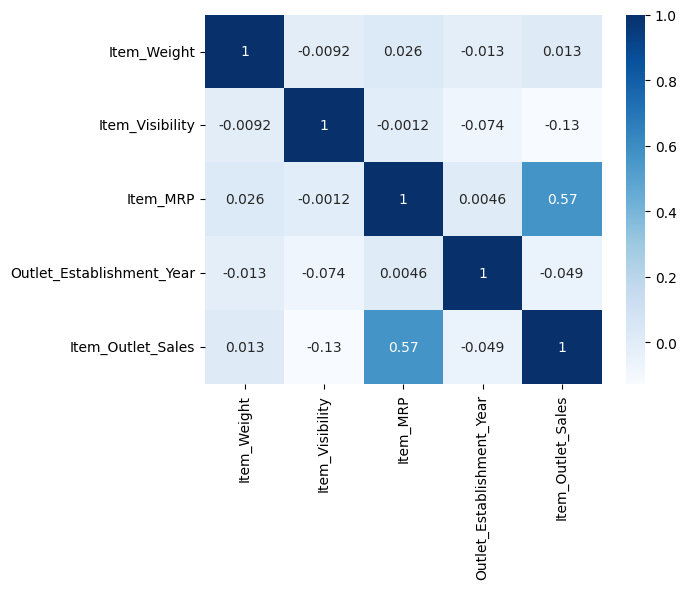

In [20]:
corr = sales.corr()
sns.heatmap(corr, cmap = 'Blues',annot=True);

* There doesn't seem to be a strong correlaton between any major columns. Item_MRP and Item_Outlet_Sales have a positive correlation of 0.57, which intuitively makes sense. 
* Next I want to dig into the columns individually. 
  * Note: I will not show the iterations for the graphs below as it will take up too much real estate, I will just show the final product.

* I am going to run similar code multiple times, so I'll create some simple functions to explore each column.

In [21]:
def catdata(data, columns):
  print(f'Count of Values: \n{data[columns].value_counts()} \n')
  print(f'Statistical Description: \n {data[columns].describe()}')
  labelorder = data.value_counts(subset = columns).index
  figmain, axmain = plt.subplots(figsize =(8,4))

  sns.countplot(data = data, y = columns, order = labelorder)
  axmain.set_title(f'Counts for {columns}', fontsize = 12)
  figmain.show()

def numdata(data,columns):
  print(f'Statistical Description: \n {data[columns].describe()} \n')
  #labelorder = data.value_counts(subset = columns).index
  figmain, axmain = plt.subplots(ncols = 2, figsize =(16,4))

  sns.histplot(data = data, x = columns, ax = axmain[0])
  axmain[0].set_title(f'Histogram distribution for {columns}', fontsize = 12)
  sns.boxplot(data = data, x = columns, ax = axmain[1])
  axmain[1].set_title(f'Boxplot Distribution for {columns}', fontsize = 12)
  figmain.suptitle(f'Hist & Boxplot for {columns}', fontsize = 18)
  figmain.tight_layout()
 
  figmain.show()


### 4-2 Numerical Data
* Now to dig into the columns using these functions, starting with the numerical data
  * Item_Weight
  * Item_Visibility
  * Item_MRP
  * Item_Outlet_Sales

Statistical Description: 
 count    8519.000000
mean       12.875420
std         4.646098
min         4.555000
25%         8.785000
50%        12.650000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64 



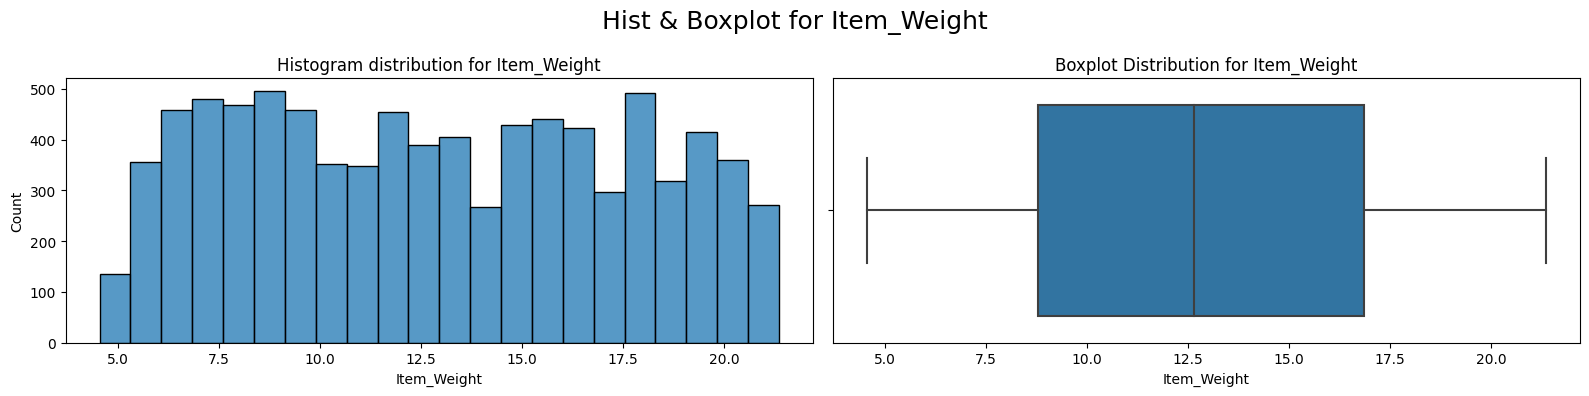

In [22]:
numdata(sales,'Item_Weight')

* This has a somewhat normal distribution with no outliers to show

Statistical Description: 
 count    8519.000000
mean        0.066112
std         0.051586
min         0.000000
25%         0.026983
50%         0.053925
75%         0.094558
max         0.328391
Name: Item_Visibility, dtype: float64 



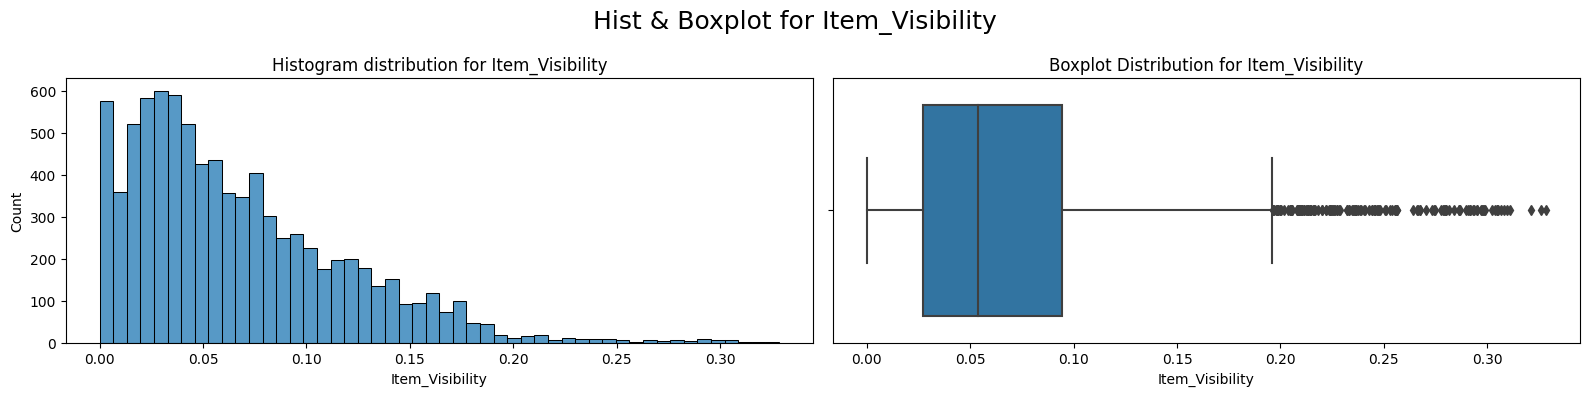

In [23]:
numdata(sales,'Item_Visibility')

* We can see that most of the data is concentrated below 0.10 for Item Visibility. The data has positive skew, and there are a lot of outliers.

Statistical Description: 
 count    8519.000000
mean      141.010019
std        62.283594
min        31.290000
25%        93.844900
50%       143.047000
75%       185.676600
max       266.888400
Name: Item_MRP, dtype: float64 



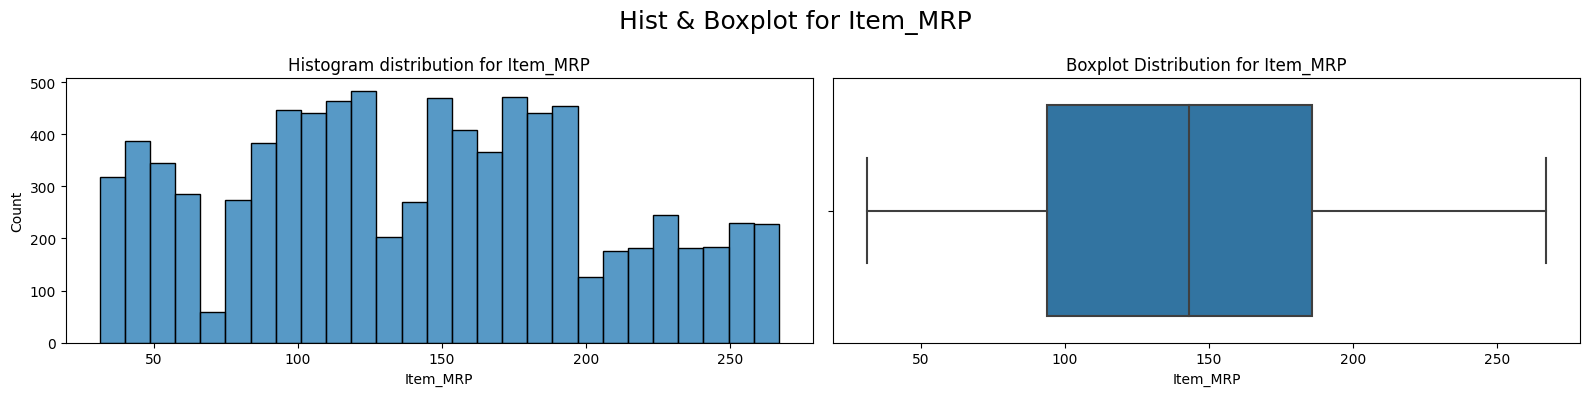

In [24]:
numdata(sales, 'Item_MRP')

* Item MRP has a somewhat normal distribution, with some negative skew. No outliers

Statistical Description: 
 count     8519.000000
mean      2181.188779
std       1706.511093
min         33.290000
25%        834.247400
50%       1794.331000
75%       3100.630600
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64 



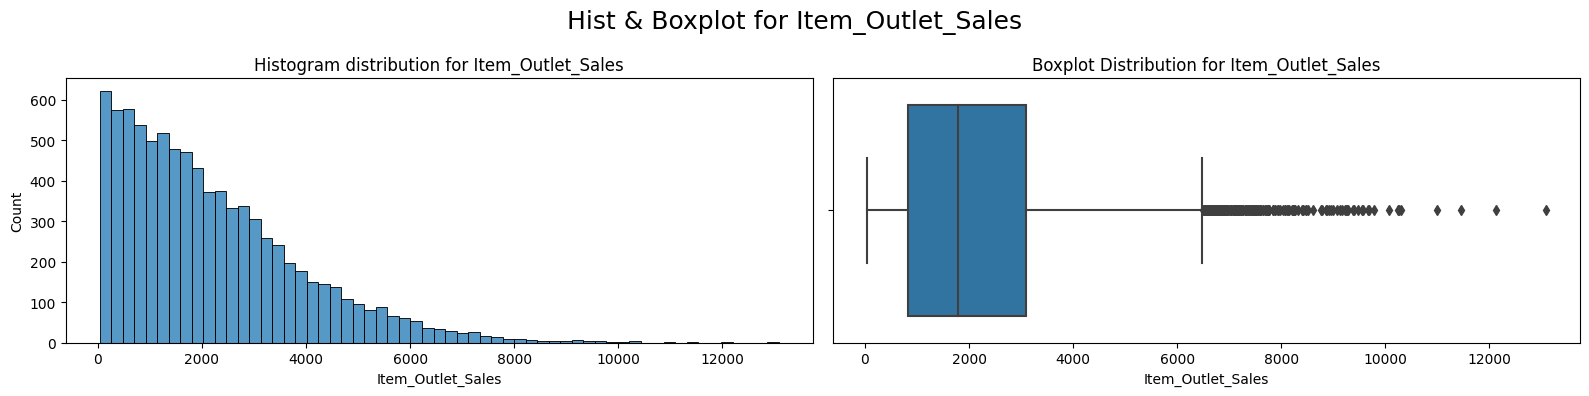

In [25]:
numdata(sales, 'Item_Outlet_Sales')

* Left to right descending histogram. Most of the data is below 3k, with a lot of outliers past the boxplot maximum.

### 4-3 Categorical Data
* Now to work on the categorical data
  *  Item_Fat_Content
  *  Item_Type
  *  Outlet_Location_Type
  *  Outlet_Type
  *  Outlet_Size
  *  Outlet_Establishment_Year

Count of Values: 
Low Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64 

Statistical Description: 
 count        8519
unique          2
top       Low Fat
freq         5516
Name: Item_Fat_Content, dtype: object


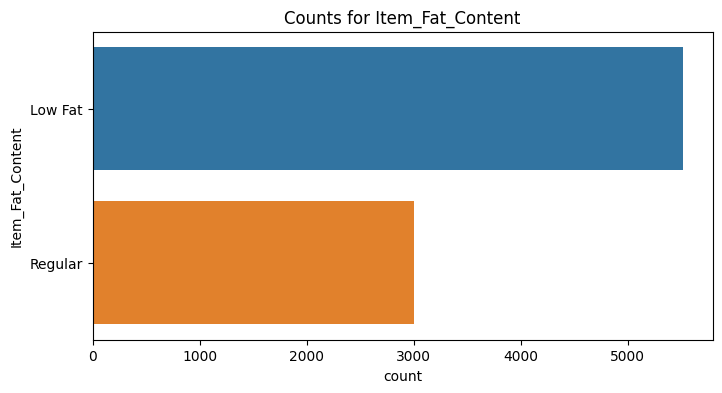

In [26]:
catdata(sales, 'Item_Fat_Content')

* Most items are Low Fat. 2 values

Count of Values: 
Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64 

Statistical Description: 
 count                      8519
unique                       16
top       Fruits and Vegetables
freq                       1232
Name: Item_Type, dtype: object


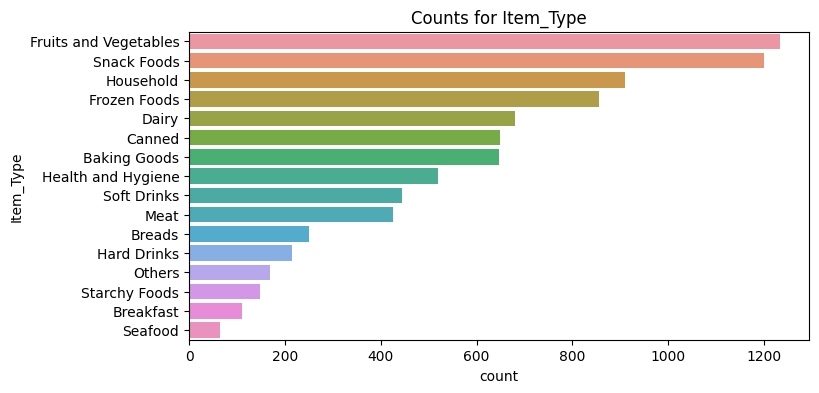

In [27]:
catdata(sales, 'Item_Type')

* Most of the items are Fruits and Vegetables. There is a large discrepancy between the top items and the bottom items.

Count of Values: 
Tier 3    3347
Tier 2    2785
Tier 1    2387
Name: Outlet_Location_Type, dtype: int64 

Statistical Description: 
 count       8519
unique         3
top       Tier 3
freq        3347
Name: Outlet_Location_Type, dtype: object


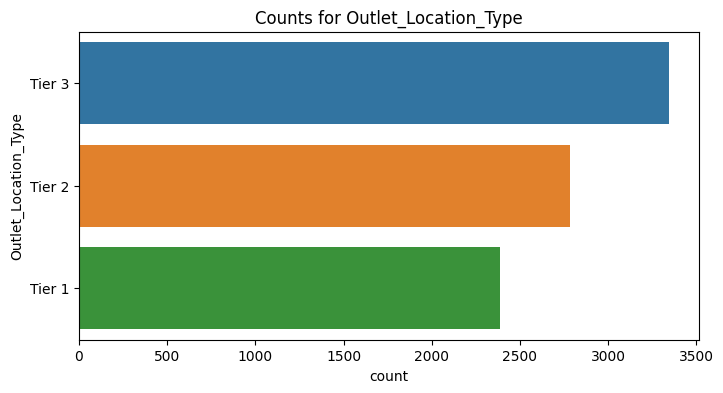

In [28]:
catdata(sales, 'Outlet_Location_Type')

* Somewhat close in value here. Tier 3 is the most common type of location, while tier 1 is the least common in the dataset

Count of Values: 
Supermarket Type1    5577
Grocery Store        1082
Supermarket Type3     932
Supermarket Type2     928
Name: Outlet_Type, dtype: int64 

Statistical Description: 
 count                  8519
unique                    4
top       Supermarket Type1
freq                   5577
Name: Outlet_Type, dtype: object


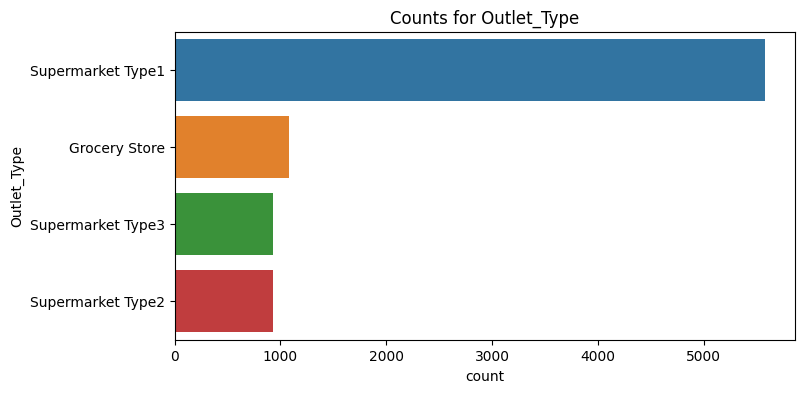

In [29]:
catdata(sales, 'Outlet_Type')

* Almost all supermarket type1's. Curious that the other 3 labels are tightly grouped

Count of Values: 
Medium     2790
Unknown    2410
Small      2387
Large       932
Name: Outlet_Size, dtype: int64 

Statistical Description: 
 count       8519
unique         4
top       Medium
freq        2790
Name: Outlet_Size, dtype: object


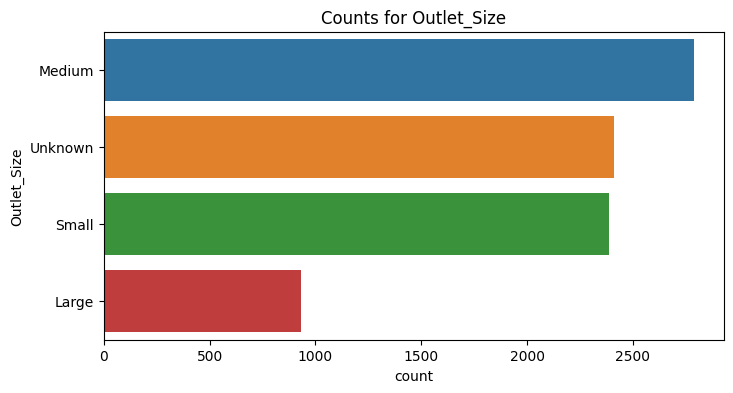

In [30]:
catdata(sales, 'Outlet_Size')

* Medium is the most common, followed by Unknown. Large is by far the least common.

Count of Values: 
1985    1459
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64 

Statistical Description: 
 count    8519.000000
mean     1997.837892
std         8.369105
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64


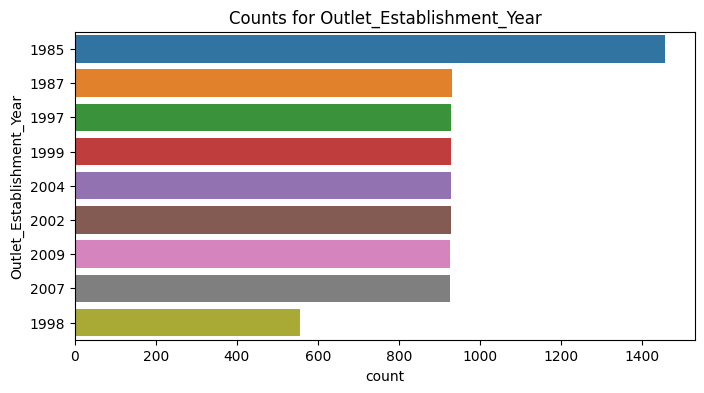

In [31]:
catdata(sales, 'Outlet_Establishment_Year')

* The function I built did not produce a good chart, as I would like to see this bar chart sorted by year. But we can see that the year where the most outlets were established was 1985, which is also the first year. After that we see a steady ~930 outlets being established
* For fun, lets create a better graph. It will be the same graph as above but without ordering the labels by the values.

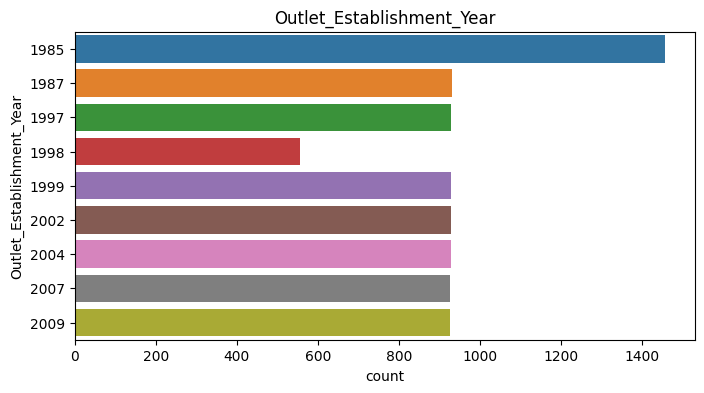

In [32]:
fig2, ax2 = plt.subplots(figsize = (8,4))
sns.countplot(data = sales, y = 'Outlet_Establishment_Year', ax = ax2)
ax2.set_title('Outlet_Establishment_Year');

## 5- Explanatory Visuals

Now to start finding trends in the data between features. I first want to start with sales by outlet, then get further and further into the data. 
* Does Outlet Size or Outlet Type affect Sales?

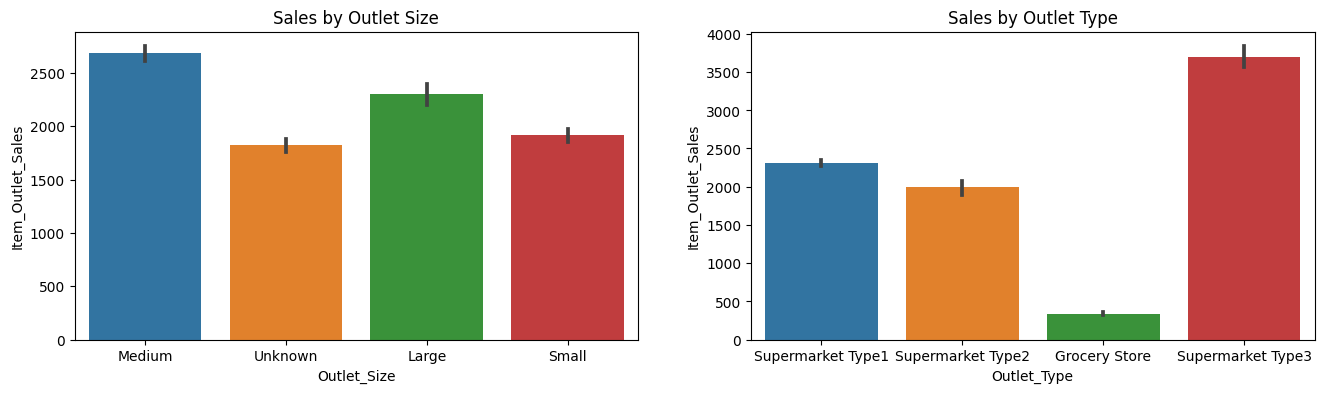

In [33]:
fig, ax = plt.subplots(ncols = 2, figsize = (16,4))

sns.barplot(data = sales, x = 'Outlet_Size', y ='Item_Outlet_Sales', ax = ax[0])
sns.barplot(data = sales, x = 'Outlet_Type', y = 'Item_Outlet_Sales', ax = ax[1])
ax[0].set_title('Sales by Outlet Size')
ax[1].set_title('Sales by Outlet Type');

* Outlet Size shows that Medium outlets sell the most on average.
* Curious to see that Supermarket Type3 has the most average sales, while Supermarket Type1 has the most records.

I want to see the combination of size and type.

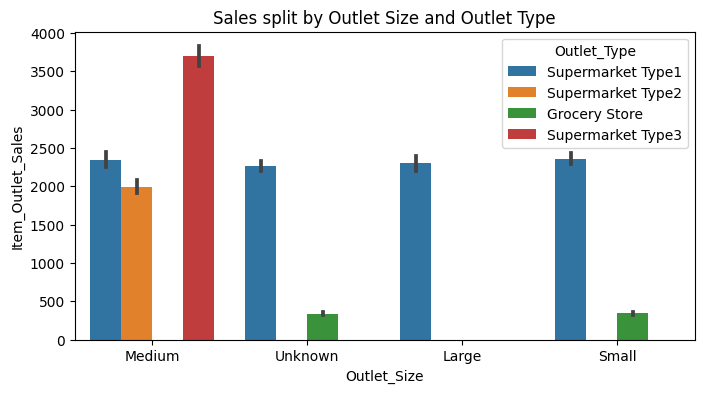

In [34]:
fig, ax = plt.subplots(figsize = (8,4))

sns.barplot(data=sales, x = 'Outlet_Size', y = 'Item_Outlet_Sales', hue = 'Outlet_Type', ax = ax)
ax.set_title('Sales split by Outlet Size and Outlet Type');

* We can see that Type1 has even sales averages, regardless of Outlet_Size. While all Supermarket Type3 is Medium.

Now lets take a look at Location Type and sales.

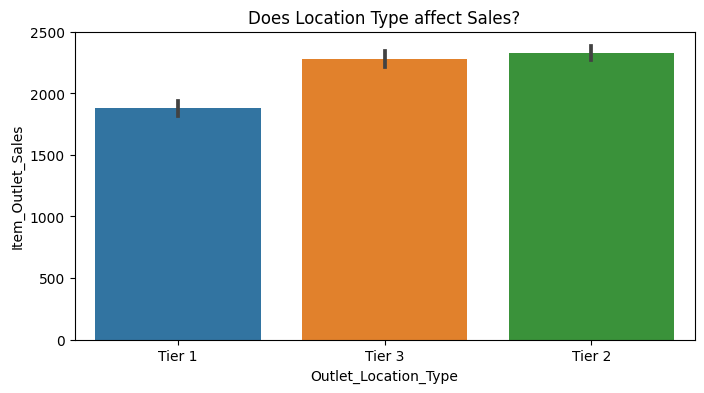

In [35]:
fig, ax = plt.subplots(figsize = (8,4))

sns.barplot(data = sales, x = 'Outlet_Location_Type', y = 'Item_Outlet_Sales', ax = ax)
ax.set_title('Does Location Type affect Sales?');

Tier 3 and 2 have very similar average sales, while Tier 1 shows the lowest average.

* I want to know if older outlets have higher sales

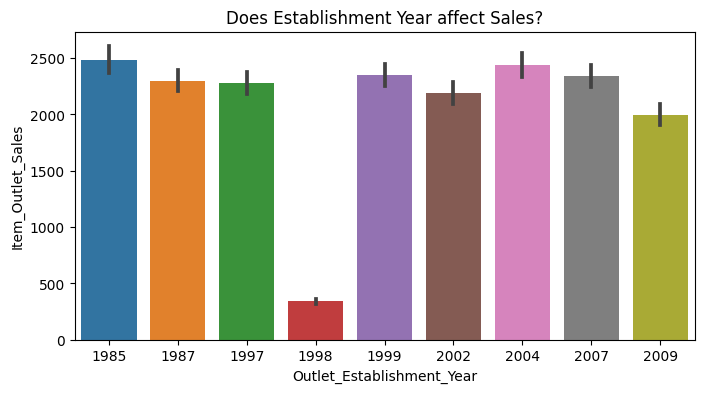

In [36]:
fig, ax = plt.subplots(figsize = (8,4))

sns.barplot(data = sales, x = 'Outlet_Establishment_Year', y = 'Item_Outlet_Sales', ax = ax)
ax.set_title('Does Establishment Year affect Sales?');

The 1998 outlets are not doing too great. The rest are close, and the oldest outlets are averaging the most in sales. 

Now I want to dig into the item types. 
* Does Item Visibility impact Sales?

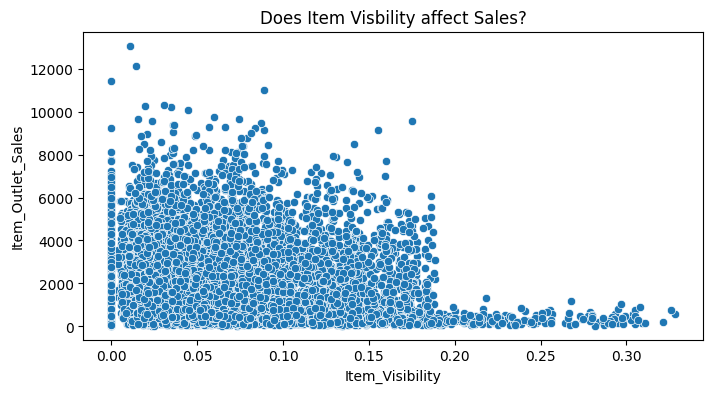

In [37]:
fig, ax = plt.subplots(figsize = (8,4))

sns.scatterplot(data = sales, x = 'Item_Visibility', y = 'Item_Outlet_Sales', ax = ax)
ax.set_title('Does Item Visbility affect Sales?');

I dont see a strong relationship here. Lets try weight.

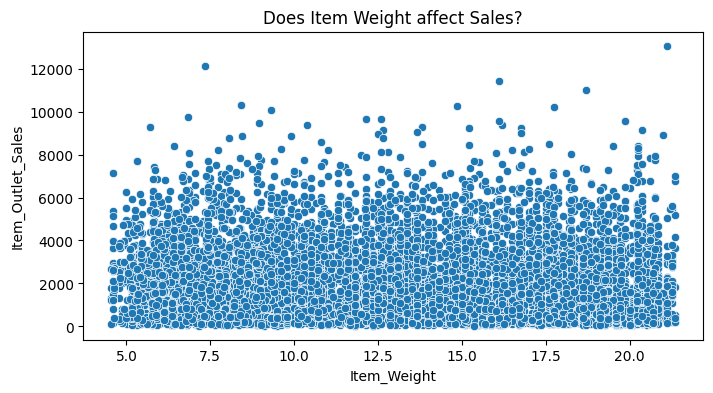

In [38]:
fig, ax = plt.subplots(figsize = (8,4))

sns.scatterplot(data = sales, x = 'Item_Weight', y = 'Item_Outlet_Sales', ax = ax)
ax.set_title('Does Item Weight affect Sales?');

Also not strong. Now I want to try fat content

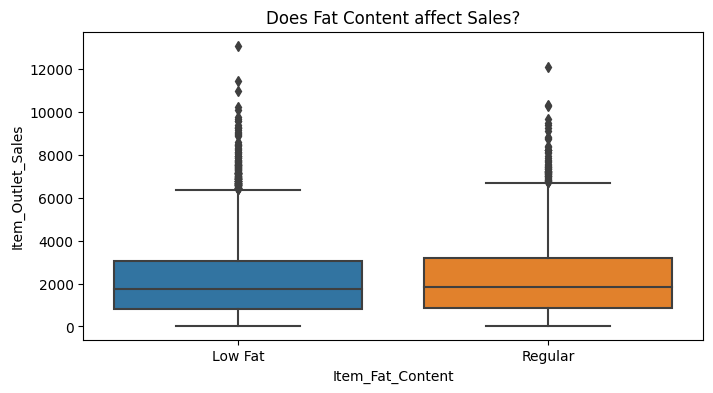

In [39]:
fig, ax = plt.subplots(figsize = (8,4))

sns.boxplot(data = sales, x = 'Item_Fat_Content', y = 'Item_Outlet_Sales', ax = ax)
ax.set_title('Does Fat Content affect Sales?');

This looks very tight, although Low Fat has some higher outliers. Now to look at item type. 
* Does item type impact sales?

Value counts for Item_Type: 
 Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
 



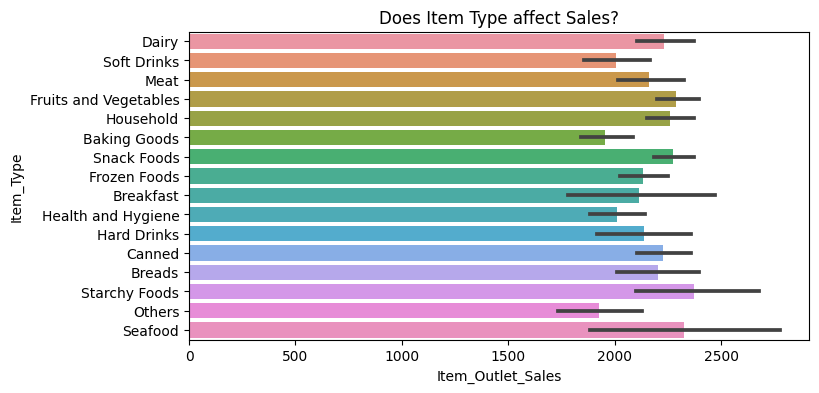

In [40]:
print(f"Value counts for Item_Type: \n {sales['Item_Type'].value_counts()}\n \n")
fig, ax = plt.subplots(figsize = (8,4))

sns.barplot(data = sales, y = 'Item_Type', x = 'Item_Outlet_Sales', ax = ax)
ax.set_title('Does Item Type affect Sales?');

Although Seafood only has 64 entries in the table, the average Item_Outlet_Sales is just as high as the other item types, with higher error bars. Others and Baking Goods are the ones with the least average sales. 
* Now lets look at Item_MRP vs Sales.

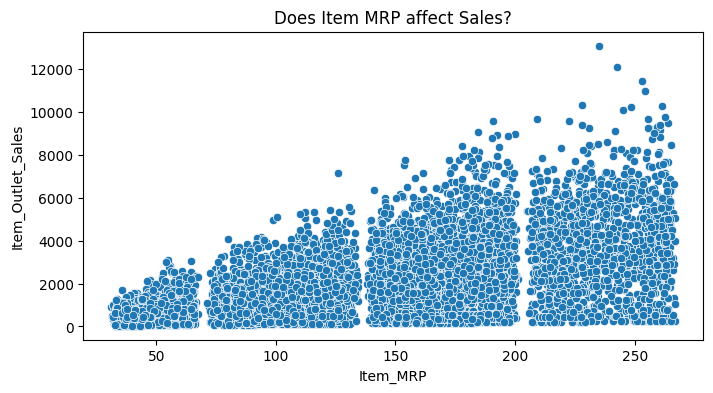

In [41]:
fig, ax = plt.subplots(figsize = (8,4))

sns.scatterplot(data = sales, x = 'Item_MRP', y = 'Item_Outlet_Sales', ax = ax)
ax.set_title('Does Item MRP affect Sales?');

We see a positive correlation here. We also saw that on the heatmap in a prior cell. 


## 6- Pre-Processing for Machine Learning

In the previous sections, I explored the data manually using pandas. I'm going to start from scratch with the dataset assigned to a new dataframe and process the data with transformers and pipelines. Going down this path will also stop any data leakage between the test and training data

### 6.1 Importing new Libraries

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

In [43]:
df2 = pd.read_csv('/content/drive/MyDrive/Datafiles/sales_predictions.csv')
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### 6.2 Cleaning the Data
* We are going to handle the null values with SimpleImputer, but first lets take a look at some categorical data. We know from before that Item_Fat_Content had some inconsistencies, its also Ordinal, with low fat being less than regular. Outlet_Size seems Ordinal as well, so I will Ordinal encode those too.

In [45]:
df2['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [46]:
df2['Item_Fat_Content'].replace({'Low Fat':0,'LF':0,'low fat':0,'Regular':1,'reg':1},inplace = True)
df2['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

In [47]:
df2['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [48]:
df2['Outlet_Size'].replace({'Small':0,'Medium':1,'High':2}, inplace = True)
df2['Outlet_Size'].value_counts()

1.0    2793
0.0    2388
2.0     932
Name: Outlet_Size, dtype: int64

* The remaining columns are nominal or categorical, so I will use some pipelines to clean them up

### 6.3 Splitting our data
The question we want to answer here is: Can we predict Item_Outlet_Sales given item weight, item fat content, item visibility, item type, item mrp, outlet establishment year, outlet size, outlet location type, and outlet type. Meaning our X will be a Pre-Processed matrix containing those features, and our y will be a vector of Item_Outlet_Sales

In [49]:
y = df2['Item_Outlet_Sales']
X = df2.drop(columns = ['Item_Identifier','Outlet_Identifier', 'Item_Outlet_Sales'])

X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,9.30,0,0.016047,Dairy,249.8092,1999,1.0,Tier 1,Supermarket Type1
1,5.92,1,0.019278,Soft Drinks,48.2692,2009,1.0,Tier 3,Supermarket Type2
2,17.50,0,0.016760,Meat,141.6180,1999,1.0,Tier 1,Supermarket Type1
3,19.20,1,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store
4,8.93,0,0.000000,Household,53.8614,1987,2.0,Tier 3,Supermarket Type1


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,0,0.029565,Household,256.4646,2009,1.0,Tier 3,Supermarket Type2
7510,15.250,1,0.000000,Snack Foods,179.7660,2009,1.0,Tier 3,Supermarket Type2
5828,12.350,1,0.158716,Meat,157.2946,1999,1.0,Tier 1,Supermarket Type1
5327,7.975,0,0.014628,Baking Goods,82.3250,2004,0.0,Tier 2,Supermarket Type1
4810,19.350,0,0.016645,Frozen Foods,120.9098,2002,NaN,Tier 2,Supermarket Type1


### 6.4 Creating our Pre-Processing Instances

In [51]:
# Scaler and Encoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore')

# Column Selectors
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

# Imputers
mean_imputer = SimpleImputer(strategy = 'mean')
const_imputer = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')

# Pipelines
num_pipeline = make_pipeline(mean_imputer, scaler)
cat_pipeline = make_pipeline(const_imputer, ohe)

# Tuples for the Transformer
num_tuple = (num_pipeline, num_selector)
cat_tuple = (cat_pipeline, cat_selector)

# Transformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder = 'drop')

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a9980670>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a99806d0>)])

* Now to fit the Transformer to the training dataset and transform it!

### 6.5 Fitting and Transforming

In [52]:
preprocessor.fit(X_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a9980670>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a99806d0>)])

In [53]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in training data are', X_train_processed.dtype)
print('All data in testing are', X_test_processed.dtype)
print('\n')
print('shape of training data is', X_train_processed.shape)
print('shape of testing data is', X_test_processed.shape)
print('\n')
X_train_processed[0:5]

0 missing values in training data
0 missing values in testing data


All data in training data are float64
All data in testing are float64


shape of training data is (6392, 29)
shape of testing data is (2131, 29)




array([[ 0.81724868, -0.7403206 , -0.71277507,  1.82810922,  1.32784893,
         0.40778536,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.5563395 ,  1.35076614, -1.29105225,  0.60336888,  1.32784893,
         0.40778536,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [-0.13151196,  1.35076614,  1.81331864,  0.24454056,  0.13618724,
         0.40778536,  0.        ,  0.        ,  0.        ,  0.        ,
  

* The Training and Test data is now in a NumPy array and is ready to be used for predictions.

## 7- Modeling
Now that we have our preprocessor built, lets instantiate some models

### 7.1 Importing new Libraries

In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### 7.2 Function for Scoring

In [55]:
def model_eval(y_true, y_hat, name = 'Model'):
  mae = mean_absolute_error(y_true, y_hat)
  mse = mean_squared_error(y_true, y_hat)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_hat)
  print(f'Metrics for {name}')
  print(f'MAE: {mae:,.4f}\nMSE: {mse:,.4f}\nRMSE: {rmse:,.4f}\nR2: {r2:,.4f}\n')

### 7.2 Linear Regression
Lets instantiate the model and add it to a pipeline for fitting.

In [56]:
lin_reg = LinearRegression()

# Making a pipeline
lin_pipe = make_pipeline(preprocessor, lin_reg)

In [57]:
lin_pipe.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a9980670>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a99806d0>)])),
                ('linearregression', LinearRegression())])

In [58]:
# Predict
y_hat_train_linear = lin_pipe.predict(X_train)
y_hat_test_linear = lin_pipe.predict(X_test)

# Score
model_eval(y_train, y_hat_train_linear, 'LR Train')
model_eval(y_test, y_hat_test_linear, 'LR Test')

Metrics for LR Train
MAE: 847.5341
MSE: 1,300,485.3347
RMSE: 1,140.3882
R2: 0.5606

Metrics for LR Test
MAE: 805.3910
MSE: 1,197,831.2718
RMSE: 1,094.4548
R2: 0.5658



#### 7.2.1 Observations
* This model is not overfit to the training data.
* This model produced a .57 R2
* The MAE and RMSE are both below the mean and std dev for the target vector.

### 7.3 Decision Tree
Same here, lets instantiate the model and make the pipeline

In [59]:
# Instantiate the model
dec_tree = DecisionTreeRegressor(random_state = 42)

# Making the pipeline
dt_pipe = make_pipeline(preprocessor, dec_tree)

In [60]:
dt_pipe.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a9980670>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a99806d0>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [61]:
# Predict
y_hat_train_dt = dt_pipe.predict(X_train)
y_hat_test_dt = dt_pipe.predict(X_test)

# Score
model_eval(y_train, y_hat_train_dt, 'DT Train')
model_eval(y_test, y_hat_test_dt, 'DT Test')

Metrics for DT Train
MAE: 0.0000
MSE: 0.0000
RMSE: 0.0000
R2: 1.0000

Metrics for DT Test
MAE: 1,031.9000
MSE: 2,204,224.7742
RMSE: 1,484.6632
R2: 0.2011



#### 7.3.1 Untuned DT
The model is clearly overfit to the training data, lets tune the depth to see if we can do better

In [62]:
dt_pipe['decisiontreeregressor'].get_depth()

40

* I'm going to loop through the depths to find the best depth for this dataset, starting with a max of 40

In [63]:
# Creating a list of depths and a dataframe to store the results in:
depths = list(range(2,41))
scoresdt = pd.DataFrame(index = depths, columns = ['Test Score', 'Train Score'])

# Looping through depths
for i in depths:
  tree = DecisionTreeRegressor(random_state = 42, max_depth = i)
  pipe = make_pipeline(preprocessor, tree)
  pipe.fit(X_train, y_train)
  # Storing the results in arrays
  train_pred = pipe.predict(X_train)
  test_pred = pipe.predict(X_test)
  # Scoring
  test_score = r2_score(y_test, test_pred)
  train_score = r2_score(y_train, train_pred)

  scoresdt.loc[i,'Test Score'] = test_score
  scoresdt.loc[i,'Train Score'] = train_score

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

<Axes: >

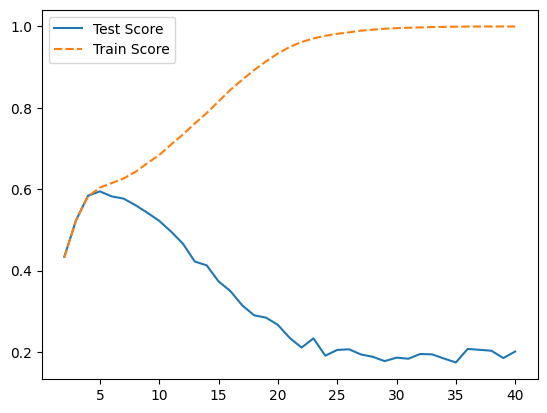

In [64]:
sns.lineplot(data = scoresdt)

In [65]:
scoresdt.sort_values(by = 'Test Score', ascending = False).index[0]

5

* It looks like 5 is the best depth for the tree

#### 7.3.2 Tuned Tree

In [66]:
best_dt = DecisionTreeRegressor(random_state = 42, max_depth = 5)

best_dt_pipe = make_pipeline(preprocessor, best_dt)

best_dt_pipe.fit(X_train, y_train)

model_eval(y_train, best_dt_pipe.predict(X_train), name = 'DT Training')
model_eval(y_test, best_dt_pipe.predict(X_test), name = 'DT Testing')

Metrics for DT Training
MAE: 762.6102
MSE: 1,172,122.7729
RMSE: 1,082.6462
R2: 0.6039

Metrics for DT Testing
MAE: 738.3173
MSE: 1,118,185.9731
RMSE: 1,057.4431
R2: 0.5947



/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


* This is much better than the untuned model, and is outperforming Linear Regression on R2 and RMSE/MAE

### 7.4 Random Forest
I want to try and beat these two models with a random forest

In [67]:
RF = RandomForestRegressor(random_state = 42)

RFpipe = make_pipeline(preprocessor, RF)

RFpipe.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a9980670>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a99806d0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

* Now lets test out the base model

In [68]:
model_eval(y_train, RFpipe.predict(X_train), name = 'RF Training')
model_eval(y_test, RFpipe.predict(X_test), name = 'RF Testing')

Metrics for RF Training
MAE: 297.3977
MSE: 183,479.1049
RMSE: 428.3446
R2: 0.9380

Metrics for RF Testing
MAE: 771.6939
MSE: 1,239,470.5343
RMSE: 1,113.3151
R2: 0.5508



#### 7.4.1 Untuned RF tree
Not bad without tuning. lets see if we can optimize it by changing the estimators and the depths

#### 7.4.2 Estimators

In [69]:
# Creating an array of estimators and a dataframe
estimators = np.linspace(10,300,30, dtype = int)
scoresrfe = pd.DataFrame(index = estimators, columns = ['Test Score', 'Training Score'])
# Looping through estimators
for i in estimators:
  Rtree = RandomForestRegressor(random_state = 42, n_estimators = i)
  RtreePipe = make_pipeline(preprocessor, Rtree)
  RtreePipe.fit(X_train, y_train)
  
  # Predicting and scoring
  train_pred_rf = RtreePipe.predict(X_train)
  test_pred_rf = RtreePipe.predict(X_test)
  train_score = r2_score(y_train, train_pred_rf)
  test_score = r2_score(y_test, test_pred_rf)

  # Storing in dataframe
  scoresrfe.loc[i,'Test Score'] = test_score
  scoresrfe.loc[i,'Training Score'] = train_score

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

<Axes: >

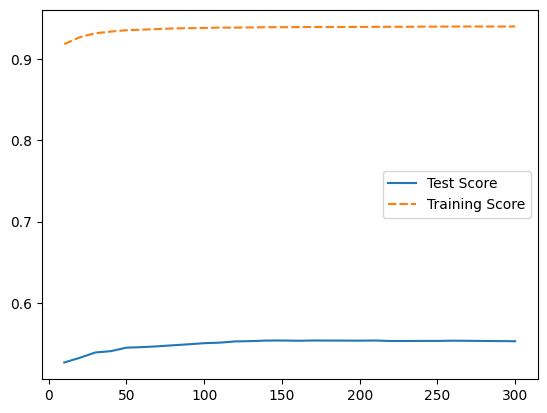

In [70]:
sns.lineplot(data = scoresrfe)

In [71]:
scoresrfe.sort_values(by = 'Test Score', ascending = False).head()

,Test Score,Training Score
150,0.554032,0.93885
170,0.554011,0.939124
210,0.554009,0.939325
180,0.553975,0.939164
140,0.553948,0.938889


* It looks like 150 was the best number of estimators. The rest of the estimators were very close. Now lets tune depth 

#### 7.4.3 Depth

In [72]:
# Looping through the estimators to get the max depth
depths = [estimator.get_depth() for estimator in RFpipe['randomforestregressor'].estimators_]
max(depths)

43

In [73]:
depths_rf = list(range(2,44))
scoresrfd = pd.DataFrame(index=depths_rf, columns = ['Test Score', 'Training Score'])
for i in depths_rf:
  Rtree = RandomForestRegressor(random_state = 42, n_estimators = 150, max_depth = i)
  RtreePipe = make_pipeline(preprocessor, Rtree)
  RtreePipe.fit(X_train, y_train)
  
  # Predicting and scoring
  train_pred_rfd = RtreePipe.predict(X_train)
  test_pred_rfd = RtreePipe.predict(X_test)
  train_score = r2_score(y_train, train_pred_rfd)
  test_score = r2_score(y_test, test_pred_rfd)

  # Storing in dataframe
  scoresrfd.loc[i,'Test Score'] = test_score
  scoresrfd.loc[i,'Training Score'] = train_score

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` 

<Axes: >

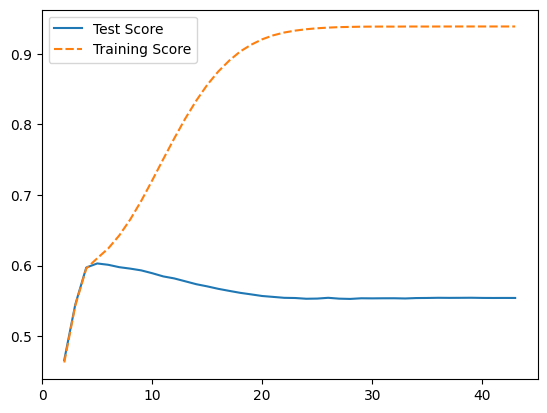

In [74]:
sns.lineplot(data = scoresrfd)

In [75]:
scoresrfd.sort_values(by = 'Test Score', ascending = False).head()

,Test Score,Training Score
5,0.602951,0.61036
6,0.60105,0.624224
7,0.597681,0.642634
4,0.597168,0.595754
8,0.595624,0.66532


* 5 is the best depth, so we will go with 5. Lets create the final Tree

#### 7.4.4 Tuned Random Forest Tree

In [76]:
best_rf = RandomForestRegressor(random_state = 42, n_estimators = 150, max_depth = 5)

best_rf_pipe = make_pipeline(preprocessor, best_rf)

best_rf_pipe.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a9980670>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa3a99806d0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, n_estimators=150,
                                       random_state=42))])

In [77]:
model_eval(y_train, best_rf_pipe.predict(X_train), name = 'RF Training')
model_eval(y_test, best_rf_pipe.predict(X_test), name = 'RF Testing')

Metrics for RF Training
MAE: 755.4773
MSE: 1,153,122.5830
RMSE: 1,073.8355
R2: 0.6104

Metrics for RF Testing
MAE: 728.3301
MSE: 1,095,450.0050
RMSE: 1,046.6375
R2: 0.6030



### 7.5 Model Discussion
* After creating 3 models, the best model is the Random Forest Model with 150 estimators and a max depth of 5.
  * This model explains 60.3% of the variance in the target variable with the chosen features. 
  * This model has a Mean Absolute Error of 728.3, far below the mean for the target. 
  * This model has a Root Mean Squared Error of 1,046.6, also below the mean for the target. 